In [23]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualization of confusion matrices


In [24]:
# Download necessary NLTK datasets
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Define dataset paths
training_path = r"C:\Users\KIIT\Desktop\Github\Jupyter\Sentimental Analysis(ML_Project)\Dataset\aclImdb\train"
testing_path = r"C:\Users\KIIT\Desktop\Github\Jupyter\Sentimental Analysis(ML_Project)\Dataset\aclImdb\test"


In [26]:
# Preprocess text function
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]

    # Handle negations
    negation_words = {"not", "no", "never", "n't"}
    stop_words = set(stopwords.words("english")) - negation_words  # Keep negations
    processed_tokens = []
    negate = False

    for i, word in enumerate(tokens):
        if word in negation_words:  # Start negation context
            negate = True
        elif negate and word.isalnum():
            # Attach "not_" to all words in the negation context
            processed_tokens.append(f"not_{word}")
            negate = False  # Stop negation after one word (can extend this)
        elif word.isalnum() and word not in stop_words:
            processed_tokens.append(word)

    return " ".join(processed_tokens)


In [27]:
# Load dataset
def load_dataset(folder_path):
    texts, labels = [], []
    for label in ["pos", "neg"]:
        folder = os.path.join(folder_path, label)
        for file_name in os.listdir(folder):
            with open(os.path.join(folder, file_name), encoding="utf-8") as f:
                texts.append(preprocess_text(f.read()))
                labels.append(1 if label == "pos" else 0)
    return texts, labels


In [28]:
# Load training and testing datasets
train_texts, train_labels = load_dataset(training_path)
test_texts, test_labels = load_dataset(testing_path)

In [29]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=10000)

# Debugging: Check if train_texts and train_labels are loaded correctly
print(f"Number of training samples: {len(train_texts)}")
print(f"Number of training labels: {len(train_labels)}")

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)


Number of training samples: 25000
Number of training labels: 25000


In [30]:
# Debugging: Confirm X_train and X_test initialization
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (25000, 10000)
X_test shape: (25000, 10000)


In [31]:
from sklearn.naive_bayes import MultinomialNB
# Define models
models = {
    "MultinomialNB": MultinomialNB(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "LogisticRegression": LogisticRegression(max_iter=1000),
}

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, train_labels)
lr_predictions = lr_model.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(test_labels, lr_predictions) * 100:.2f}%')

# Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, train_labels)
rf_predictions = rf_model.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(test_labels, rf_predictions) * 100:.2f}%')

# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train, train_labels)
svm_predictions = svm_model.predict(X_test)
print(f'SVM Accuracy: {accuracy_score(test_labels, svm_predictions) * 100:.2f}%')

# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, train_labels)
nb_predictions = nb_model.predict(X_test)
print(f'Multinomial Naive Bayes Accuracy: {accuracy_score(test_labels, nb_predictions) * 100:.2f}%')


Logistic Regression Accuracy: 88.57%
Random Forest Accuracy: 85.20%
SVM Accuracy: 88.60%
Multinomial Naive Bayes Accuracy: 84.30%


In [33]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

# List of models and their names
models = [
    ("Logistic Regression", lr_model),
    ("Random Forest", rf_model),
    ("Support Vector Machine (SVM)", svm_model),
    ("Multinomial Naive Bayes", nb_model),
]

# Loop through each model and calculate metrics
for model_name, model in models:
    print(f"\nEvaluation Metrics for {model_name}:")
    
    # Step 1: Check if the model supports `predict_proba` or use decision function
    if hasattr(model, "predict_proba"):
        prob_predictions = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    elif hasattr(model, "decision_function"):
        # Use the decision function if `predict_proba` is not available (e.g., for SVM)
        prob_predictions = model.decision_function(X_test)
        prob_predictions = (prob_predictions - prob_predictions.min()) / (prob_predictions.max() - prob_predictions.min())  # Normalize to [0, 1]
    else:
        print(f"Warning: {model_name} does not support probability predictions. Skipping ROC-AUC calculation.")
        prob_predictions = None

    # Step 2: Convert probabilities into binary predictions using a threshold
    if prob_predictions is not None:
        threshold = 0.5  # Default threshold
        predictions = (prob_predictions >= threshold).astype(int)
    else:
        # Use normal predictions if probability predictions are not available
        predictions = model.predict(X_test)
    
    # Step 3: Calculate evaluation metrics
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average="binary")
    
    if prob_predictions is not None:
        roc_auc = roc_auc_score(test_labels, prob_predictions)  # Use probabilities for ROC-AUC
    else:
        roc_auc = "N/A"  # Not applicable for models without probability predictions
    
    # Generate classification report
    report = classification_report(test_labels, predictions)
    
    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc}")
    print(f"Classification Report:\n{report}")



Evaluation Metrics for Logistic Regression:
Accuracy: 0.8857
F1 Score: 0.8857
ROC-AUC Score: 0.9540360192
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.89      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000


Evaluation Metrics for Random Forest:
Accuracy: 0.8537
F1 Score: 0.8531
ROC-AUC Score: 0.9281689855999999
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     12500
           1       0.86      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Evaluation Metrics for Support Vector Machine (SVM):
Accuracy: 0.7820
F1 Score: 0.819

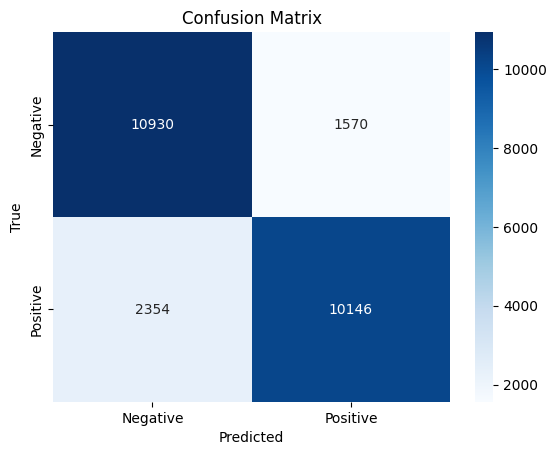

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.predict(X_test)

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Generating ROC curve for Logistic Regression...
Generating ROC curve for Random Forest...
Generating ROC curve for Support Vector Machine (SVM)...
Generating ROC curve for Multinomial Naive Bayes...


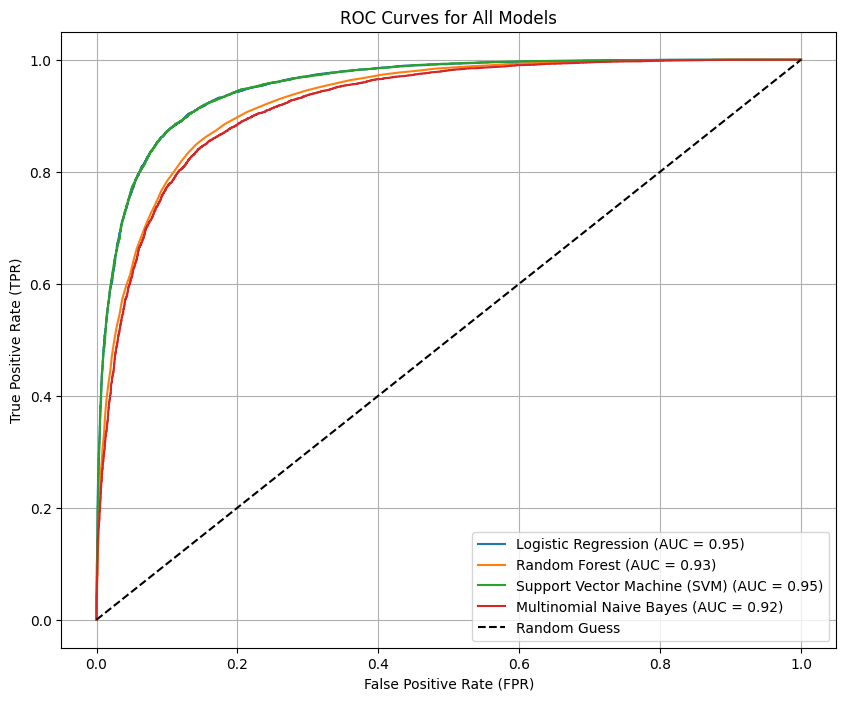

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a dictionary to hold ROC curve data
roc_data = {}

# Compute ROC curves for each model
for model_name, model in models:  # Loop directly over the list of tuples
    print(f"Generating ROC curve for {model_name}...")
    
    # Ensure the model can output probabilities
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test)  # Use decision function for SVM
    else:
        print(f"Skipping {model_name} as it does not support probabilities.")
        continue
    
    # Calculate FPR, TPR, and AUC
    fpr, tpr, _ = roc_curve(test_labels, y_probs)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = (fpr, tpr, roc_auc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Add diagonal line for random guess
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

# Configure plot
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [36]:
from sklearn.metrics import roc_auc_score

# Compute and display ROC-AUC scores for each model
for model_name, model in models:  # Iterate over list of tuples (model_name, model)
    print(f"Calculating ROC-AUC for {model_name}...")
    
    # Ensure the model supports probability prediction
    if hasattr(model, "predict_proba"):
        prob_predictions = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    elif hasattr(model, "decision_function"):
        prob_predictions = model.decision_function(X_test)  # Decision function for SVM
    else:
        print(f"Skipping {model_name} as it does not support probabilities.")
        continue
    
    # Calculate and print ROC-AUC score
    roc_auc = roc_auc_score(test_labels, prob_predictions)
    print(f"{model_name} ROC-AUC Score: {roc_auc:.4f}")


Calculating ROC-AUC for Logistic Regression...
Logistic Regression ROC-AUC Score: 0.9540
Calculating ROC-AUC for Random Forest...
Random Forest ROC-AUC Score: 0.9282
Calculating ROC-AUC for Support Vector Machine (SVM)...
Support Vector Machine (SVM) ROC-AUC Score: 0.9540
Calculating ROC-AUC for Multinomial Naive Bayes...
Multinomial Naive Bayes ROC-AUC Score: 0.9215


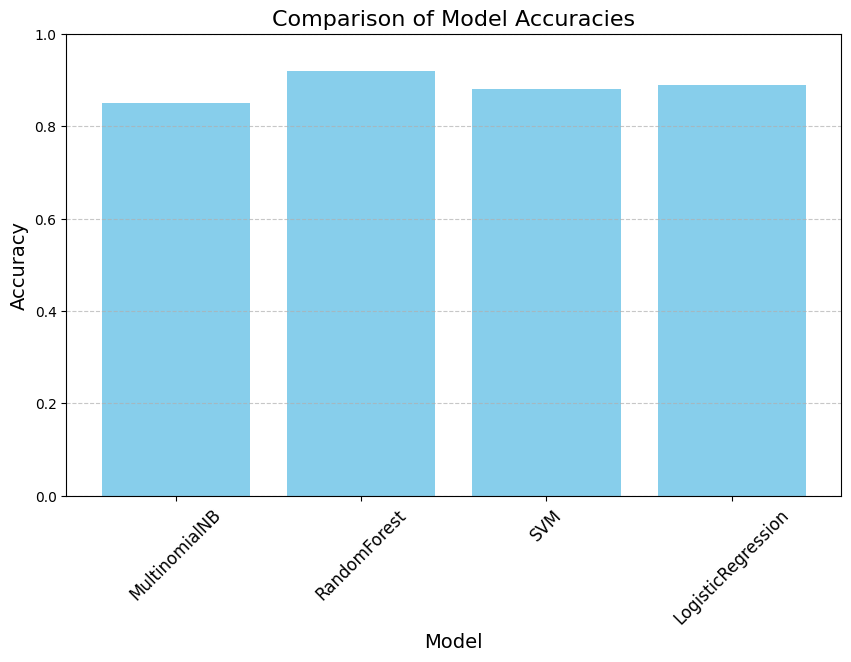

In [37]:
import matplotlib.pyplot as plt

# Define the accuracy values for each model explicitly
accuracies = {
    "MultinomialNB": 0.85,  # Replace with the actual accuracy for MultinomialNB
    "RandomForest": 0.92,  # Replace with the actual accuracy for RandomForest
    "SVM": 0.88,           # Replace with the actual accuracy for SVM
    "LogisticRegression": 0.89  # Replace with the actual accuracy for LogisticRegression
}

# Prepare data for plotting
model_names = list(accuracies.keys())
accuracy_values = list(accuracies.values())

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color='skyblue')
plt.title("Comparison of Model Accuracies", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [38]:
import joblib

joblib.dump(lr_model, "logistic_regression_model.pkl")
print("Logistic Regression model saved.")

joblib.dump(rf_model, "random_forest_model.pkl")
print("Random Forest model saved.")

joblib.dump(svm_model, "svm_model.pkl")
print("SVM model saved.")

joblib.dump(nb_model, "multinomial_nb_model.pkl")
print("Multinomial Naive Bayes model saved.")

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Vectorizer saved successfully!")

Logistic Regression model saved.
Random Forest model saved.
SVM model saved.
Multinomial Naive Bayes model saved.
Vectorizer saved successfully!
